In [1]:
from dotenv import load_dotenv
from langchain.vectorstores import Chroma, FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from pprint import pprint
import os

load_dotenv()
os.getenv('TEST')

'Success'

In [5]:
db = 'Chroma'
collection='earnings'
persist_directory = f'./ignore/{db}/{collection}'

embedding_function = OpenAIEmbeddings(deployment="SL-document_embedder",
                                      model='text-embedding-ada-002') 
if db == 'Chroma':
    vector_db = Chroma(persist_directory=persist_directory, 
                       embedding_function=embedding_function)
elif db == 'FAISS':
    vector_db = FAISS.load_local(persist_directory, embedding_function)

print(vector_db._collection.count())

5


# Retrieval methods

### Basic semantic similarity search, finds k most similar queries

In [15]:
# query it
query = "What is the meaning of a Subscription economy? Give an example"
docs = vector_db.similarity_search(query, k=2)
print(f'Number of matches: {len(docs)}')
for doc in docs:
    pprint(doc.page_content)

Number of matches: 2
('the goal of business should be to start with the wants and needs of a '
 'particular customer base, then create a service that delivers ongoing value '
 'to those customers. The idea was to turn customers into subscribers in order '
 'to develop recurring revenue. I called the context for this change the '
 'Subscription Economy. Oh man, did I get a lot of crap for that article. '
 'There were comments like: Do you really think we don’t get it, Tien? That we '
 'don’t understand the difference between a product and a')
('the rapid ascent of the Subscription Economy. As I’ve mentioned previously, '
 'by 2020, we should expect to see more than 80 percent of software providers '
 'shift to subscription-based business models (according to Gartner) and 50 '
 'percent of the world’s largest enterprises depend on digitally enhanced '
 'products, services, and experiences. Recurring revenue-based business models '
 'are not new, but they have exploded in recent years owi

In [ ]:
vector_db.similarity_search_with_relevance_scores('Neural networks')

### Maximum marginal relevance, finds fetch_k most similar results, then get k most diverse results

In [16]:
query = "What is the meaning of a Subscription economy? Give an example"
docs = vector_db.max_marginal_relevance_search(query, k=2, fetch_k=4)
print(f'Number of matches: {len(docs)}')
for doc in docs:
    pprint(doc.page_content)

Number of matches: 2
('the goal of business should be to start with the wants and needs of a '
 'particular customer base, then create a service that delivers ongoing value '
 'to those customers. The idea was to turn customers into subscribers in order '
 'to develop recurring revenue. I called the context for this change the '
 'Subscription Economy. Oh man, did I get a lot of crap for that article. '
 'There were comments like: Do you really think we don’t get it, Tien? That we '
 'don’t understand the difference between a product and a')
('Today the whole world runs “as a service”: transportation, education, media, '
 'health care, connected devices, retail, industry. Subscriptions themselves, '
 'of course,aren’t new. The most basic definition of a subscription is simply '
 'a piece of writing beneath a document (sub script): a name, a note, an '
 'addendum. When two parties are involved, that constitutes a mutual '
 'agreement, an accord, a relationship. As a business model, subs

### Self query
This method allows the the query to be processed as both
- semantic search for context
- and also a filter search onto the metadata

In [1]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import Chroma


docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]

vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

In [13]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]

document_content_description = "Brief summary of a movie"
llm = ChatOpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    verbose=True, 
    enable_limit=True # This allows the self query to also identify limit from the query
)

retriever.get_relevant_documents("One Animated film")

[Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]

In [10]:
retriever.get_relevant_documents("Give me two movies that came after year two thousand")

[Document(page_content='A bunch of normal-sized women are supremely wholesome and some men pine after them', metadata={'director': 'Greta Gerwig', 'rating': 8.3, 'year': 2019}),
 Document(page_content='Leo DiCaprio gets lost in a dream within a dream within a dream within a ...', metadata={'director': 'Christopher Nolan', 'rating': 8.2, 'year': 2010})]

# Question answering with semantic search + LLM

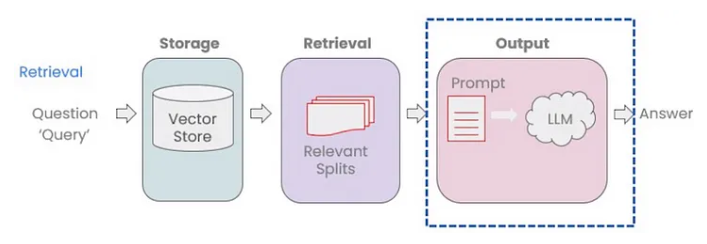

### Without using a customized prompt

In [8]:
model_name = 'gpt-3.5-turbo-1106'
llm = ChatOpenAI(model_name=model_name, temperature=0)


qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever = vector_db.as_retriever(),
    return_source_documents=True
)

query = "What are major topics for this book?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('The major topics for this book include how subscriptions are transforming '
 'different industries, tactical and operational details on applying the '
 'subscription model across all aspects of a company, industry benchmarks, '
 'relevant case studies, best practices, and guidance on transitioning a '
 'traditionally product-based company to a subscription-based revenue model.')

----------Printing source documents-----------------

Total of 4 sources
('for a basic playbook on making the shift to recurring revenue. While '
 'subscriptions have been getting a huge amount of press coverage lately, I’m '
 'going to give you the most important material, the stone tablets. In Part 1 '
 'of this book we’ll explore how subscriptions are transforming several '
 'different industries, and in Part 2 we’ll dig into more tactical, '
 'operational details about how to apply the subscription model across every '
 'aspect of your company. Here are some of the topics I’ll be')

('businesses I want t

In [9]:
query = "Did the author explain his story?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('Yes, the author explained the importance of starting with a foundational '
 'thesis or a bigger reason to exist when telling a business story. The author '
 'also emphasized the significance of understanding the context of the company '
 'within the broader commercial world before delving into the product story.')

----------Printing source documents-----------------

Total of 4 sources
('companies (especially ones here in Silicon Valley) have a pretty good grasp '
 'of the first two stories. They know what they’re selling, and who’s buying. '
 'They have nice scrolling websites filled with all sorts of product features '
 'and client case studies. But lots of them are missing a foundational thesis. '
 'A bigger reason to exist. They don’t have a why (much less a why now ). And '
 'that’s the story you should really be starting with. In a perfect world, '
 'these stories are actually heard in a')

('We were excited about our business. Things were going well, and we had an '
 'aggress

In [15]:
help(vector_db.as_retriever)

Help on method as_retriever in module langchain.schema.vectorstore:

as_retriever(**kwargs: 'Any') -> 'VectorStoreRetriever' method of langchain.vectorstores.chroma.Chroma instance
    Return VectorStoreRetriever initialized from this VectorStore.
    
    Args:
        search_type (Optional[str]): Defines the type of search that
            the Retriever should perform.
            Can be "similarity" (default), "mmr", or
            "similarity_score_threshold".
        search_kwargs (Optional[Dict]): Keyword arguments to pass to the
            search function. Can include things like:
                k: Amount of documents to return (Default: 4)
                score_threshold: Minimum relevance threshold
                    for similarity_score_threshold
                fetch_k: Amount of documents to pass to MMR algorithm (Default: 20)
                lambda_mult: Diversity of results returned by MMR;
                    1 for minimum diversity and 0 for maximum. (Default: 0.5)
 

### With a chained prompt

In [31]:
model_name = 'gpt-3.5-turbo-1106'
model = ChatOpenAI(model_name=model_name, temperature=1)

# Build prompt
template = """Use the following pieces of context to answer the question at the end. \
If you don't know the answer, just say that you don't know, don't try to make up an answer. \
Context: {context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    model,
    retriever=vector_db.as_retriever(
        search_type="mmr", # Maximum Marginal Relevance, other options include #similarity_score_threshold
        search_kwargs = {
            "k": 4,                     #k: Amount of documents to return (Default: 4)
            'score_threshold': 0.5,     # Minimum relevance threshold for similarity_score_threshold
            'fetch_k': 20,              # Amount of documents to pass to MMR algorithm (Default: 20)
            'lambda_mult': 0.5,         # Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum. (Default: 0.5)
            #'filter': {'source':'GPT-4 Technical Report'} #Filter by document metadata'search'
            }
        ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
    )

query = "Is the investment thesis on track for NVIDIA? Give me reasons. Also tell me about the lurking risks. How does this compare to other companies?"
result = qa_chain({"query": query})
pprint(result["result"])

Number of requested results 20 is greater than number of elements in index 5, updating n_results = 5


('Yes, the investment thesis for NVIDIA is on track. The company has '
 'demonstrated strong growth in revenue, profit margins, and net income, with '
 'data center revenue nearly quadrupling and the gaming segment performing '
 'well. NVIDIA has also shown strong operating leverage, returning billions to '
 'shareholders and providing upbeat guidance for future revenue growth.\n'
 '\n'
 'The lurking risks for NVIDIA include the high valuation of the stock, with '
 'the price-to-earnings ratio being at historically high levels, indicating '
 'that the expectations for future growth are already reflected in the stock '
 'price. The company also faces potential slowdown in revenue growth and the '
 'need to maintain its high gross margins.\n'
 '\n'
 'When comparing NVIDIA to other companies, its strong financial performance, '
 'innovative technologies, and market-leading position make it a top player in '
 'the semiconductor and technology industry. However, the high valuation and '
 't

In [35]:
print(f"Total of {len(result['source_documents'])} sources")
print('\n----------Printing source documents-----------------\n')
for document in result['source_documents']:
    print(document.page_content)
    print(document.metadata)
    print()

Total of 4 sources

----------Printing source documents-----------------

imagine this scenario with me for a  minute you go into a classroom of  college students you tell them there's a  $ 1.2 trillion company that is growing  its Topline by over 200% it is doubling  its profit margins it is Raising its  Outlook moving forward first of all that  is something that no company of this  size has ever done before but then you  tell them after all these great results  come in after they raise the Outlook the  stock is down on the news yes that's  actually what happened first time that a  company at this scale has done this and  shares of Nvidia which reported its  earnings last night are actually down  over 3% as of right now so why is this  happening and what does it mean for  investors we'll get into that over the  next 10 minutes my name is Brian stoel  as of the time of this recording I do  not own shares of Nvidia want to give a  shout out to why charts for sponsoring  today's video mo

## Attempt to build the chain myself using LCEL

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

template = """Answer the question based only on the following context:

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()


def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])


chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("What did the president say about technology?")

# Another interesting way is to use ready available retrievers, such as from Wikipedia
This will send API calls backend. The alternative is to use its loader, and load + split the pages to store ourselves

In [1]:
from langchain.retrievers import WikipediaRetriever
from pprint import pprint

retriever = WikipediaRetriever(
    top_k_results = 3,
    lang= "en", 
    load_all_available_meta = False,
    doc_content_chars_max = 4000
    )

docs = retriever.get_relevant_documents(query="RAG framework")
pprint(docs)

f:\python_stuff\LangChain\.venv\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file f:\python_stuff\LangChain\.venv\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


[Document(page_content='Ragging is the term used for the so-called "initiation ritual" practiced in higher education institutions in India, Pakistan, Bangladesh, and Sri Lanka. The practice is similar to hazing in North America, bizutage in France, praxe in Portugal, and other similar practices in educational institutions across the world. Ragging involves abuse, humiliation, or harassment of new entrants or junior students by the senior students. It often takes a malignant form wherein the newcomers may be subjected to psychological or physical torture.\nIn 2009, the University Grants Commission of India imposed regulations upon Indian universities to help curb ragging and launched a toll-free \'anti-ragging helpline\'.Ragging is a subset of bullying. Unlike various complex forms of bullying, ragging is easily recognisable.\nAccording to University Grants Commission (India)’s anti-ragging cell data, 511 complaints of ragging were registered in India in 2021. Inaction and underreportin